# Import Packages

In [7]:
import os
import pickle as pkl
import sys
sys.path.append('/Users/kana/Library/Mobile Documents/com~apple~CloudDocs/Codes/GWOT_colorprefrencequalia')
import numpy as np
import pandas as pd
import sklearn
import csv
from scipy.stats import pearsonr, spearmanr
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from mpl_toolkits.mplot3d import Axes3D
from sklearn.manifold import MDS
import seaborn as sns
import ot
import plotly.graph_objs as go
import plotly.express as px
from mpl_toolkits.axes_grid1 import make_axes_locatable
import math

# Our own utility functions
from utilityFunctions import show_heatmaps

# Define variables (used across the code)

In [8]:
# Define unique colors
unique_colours = np.array(['#d2b700', '#db8b08', '#c7512c', '#c13547', '#a03663', '#753a7a', '#4b488e', '#005692', '#006a8b', '#007b75', '#008a52', '#9aa400'])
colour_index = {colour: idx for idx, colour in enumerate(unique_colours)}
matrix_size = len(unique_colours)

### configuration
n_eps = 15 # number of epsilon values tried
eps_range = [0.04, 5] # the range of epsilon searched
epsilons = np.logspace(np.log10(eps_range[0]), np.log10(eps_range[1]), n_eps) # epsilon values

# Load Data

## Raw Data - List of all subject data

In [5]:
# Load datafiles for each participant and extract similarity matrices

pFiles = [] # stores source datafile for each participant, pFiles[pID] gives the file for participant pID
pCounter = 0 

pMatrices = [] # stores data matrix for each participant

for filename in os.listdir('raw_data/kana_colourpreferencequalia-master/data'):
    if filename.endswith(".csv"):
        filepath = os.path.join('raw_data/kana_colourpreferencequalia-master/data', filename)

        # This is another participant
        pFiles.append(filename)
        pCounter = pCounter + 1
        
        # Load the CSV file
        df = pd.read_csv(filepath)

        # Filter for rows where 'response_type' is 'similarity'
        df_similarity = df[df['response_type'] == 'similarity']

        # Extract columns
        colour1 = df_similarity['colour1']
        colour2 = df_similarity['colour2']
        target_preference = df_similarity['response']

        # Create and fill the matrix
        # NOTE double pass trials will overwrite the first trials (is this what we want?)
        matrix_size = len(colour_index)
        matrix = np.zeros((matrix_size, matrix_size))
        for c1, c2, tp in zip(colour1, colour2, target_preference):
            I = colour_index[c1]
            j = colour_index[c2]
            matrix[j, I] = tp

        # Store the matrix
        pMatrices.append(matrix)

pIds = range(0, pCounter)

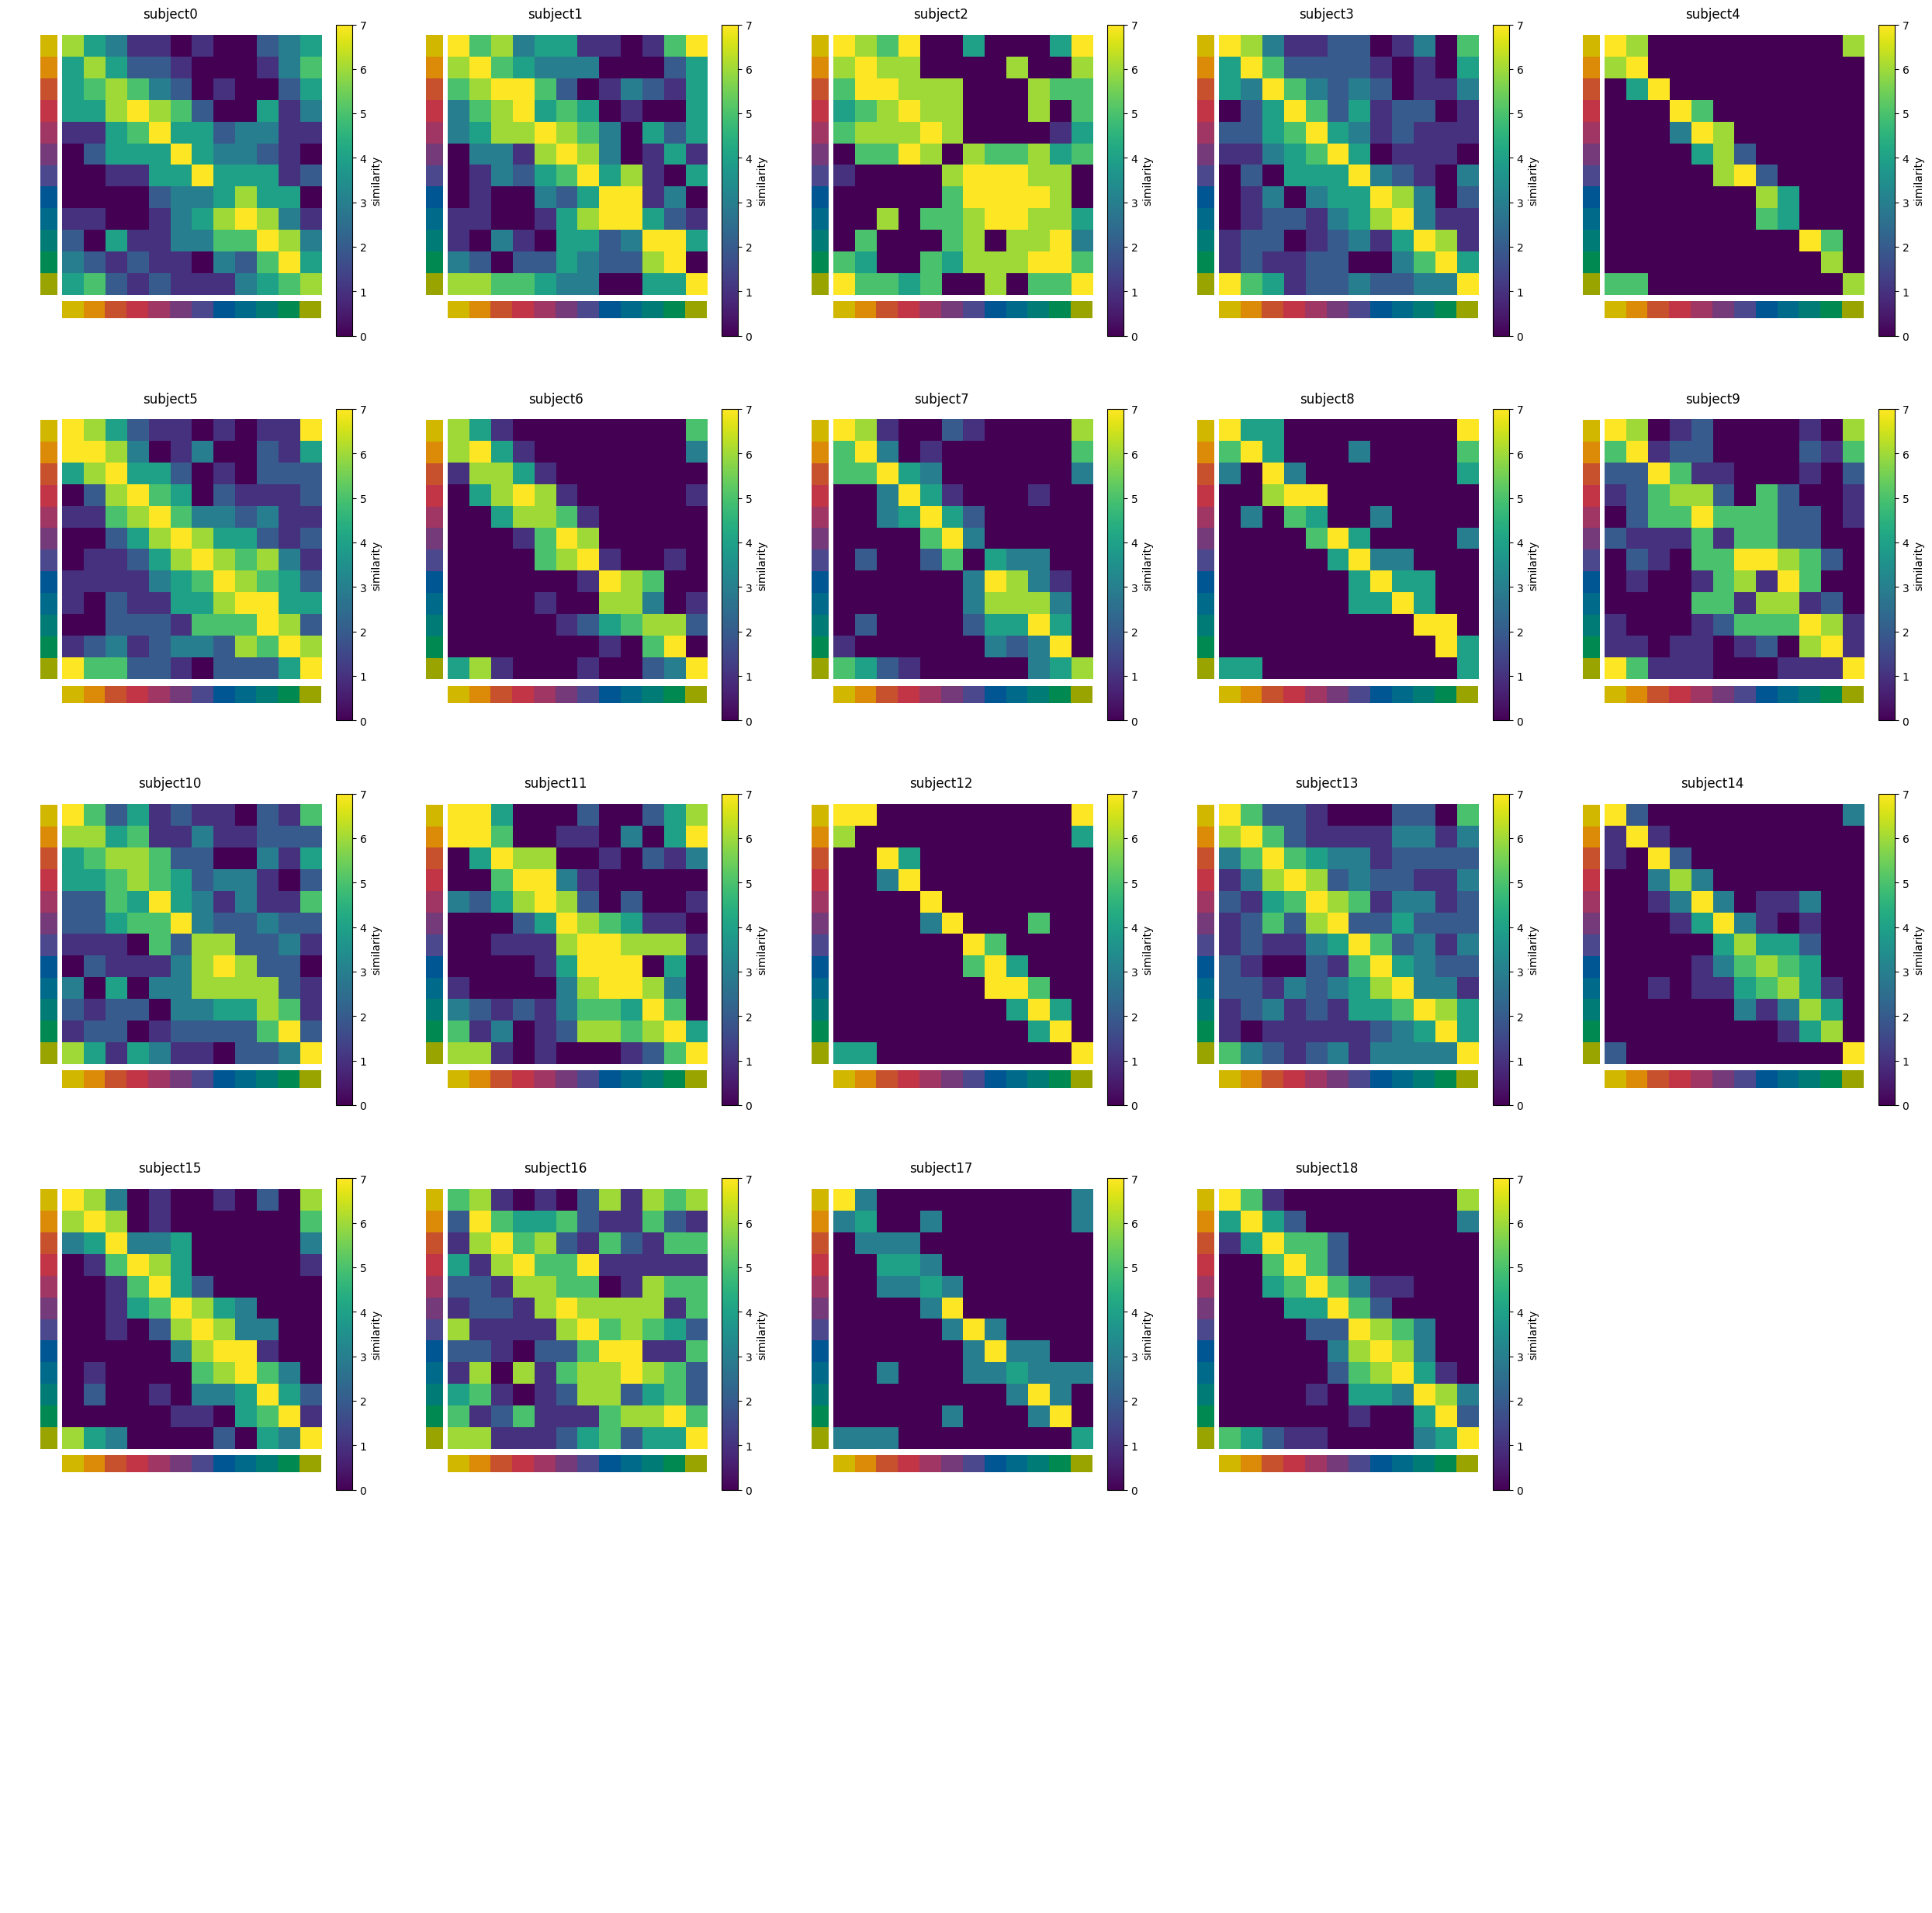

subject0 55132578fdf99b1b0568bdb8_kana_colourPreferenceQualia_2024-11-13_20h51.52.595.csv
subject1 5a9b20c535237b0001129820_kana_colourPreferenceQualia_2024-11-14_03h40.27.980.csv
subject2 5eb05d66438b180fe44f6929_kana_colourPreferenceQualia_2024-11-13_22h37.20.028.csv
subject3 609c1037e6c696620986cc20_kana_colourPreferenceQualia_2024-11-14_03h36.42.529.csv
subject4 60d1294f69a16ae3ac6301cd_kana_colourPreferenceQualia_2024-11-14_03h37.04.473.csv
subject5 61081452f93d7b4b161aa259_kana_colourPreferenceQualia_2024-11-13_20h46.56.032.csv
subject6 6171f34f6c376e1c7dd8dad0_kana_colourPreferenceQualia_2024-11-13_19h37.40.788.csv
subject7 65a3ab6491a3f0e753748680_kana_colourPreferenceQualia_2024-11-14_14h38.27.257.csv
subject8 65f13c4cbe73a841010ffca1_kana_colourPreferenceQualia_2024-11-14_08h37.56.050.csv
subject9 65f18d7e69e3e32de7794cf1_kana_colourPreferenceQualia_2024-11-14_07h08.16.789.csv
subject10 65fa3b371c3fff8d33be85bf_kana_colourPreferenceQualia_2024-11-14_07h38.27.714.csv
subject11

In [6]:
# Show matrices
show_heatmaps(0, 7, matrices=pMatrices, titles=["subject" + str(p) for p in pIds], cbar_label="similarity", color_labels=unique_colours)

for f in range(0, len(pFiles)):
    print("subject" + str(f) + ' ' + pFiles[f])


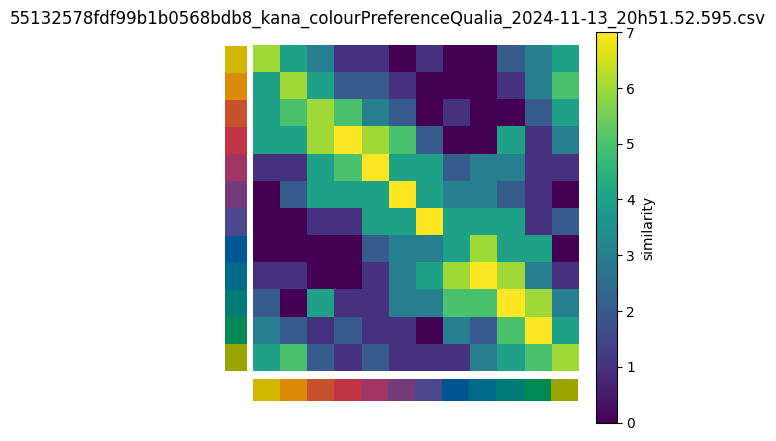

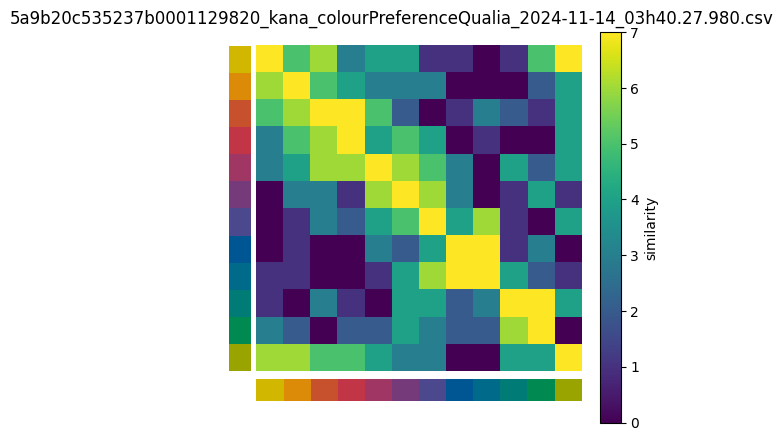

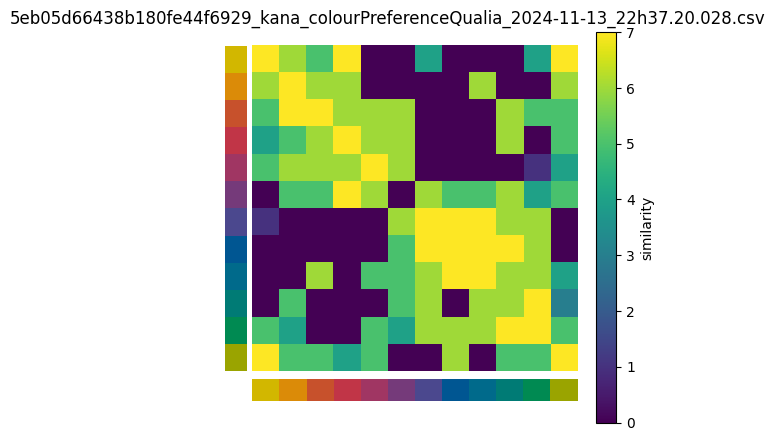

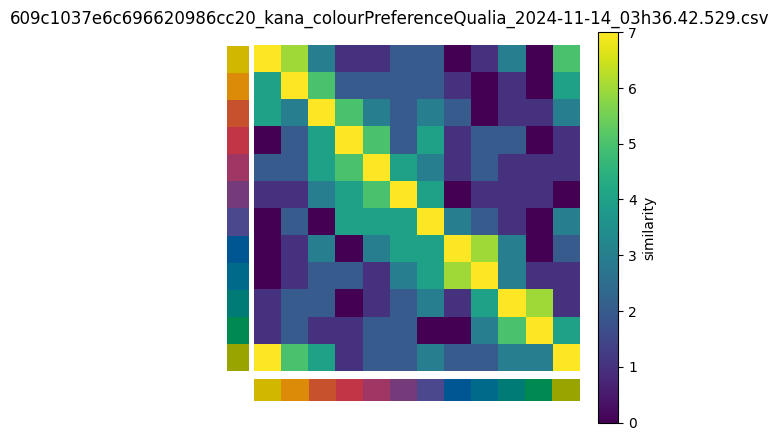

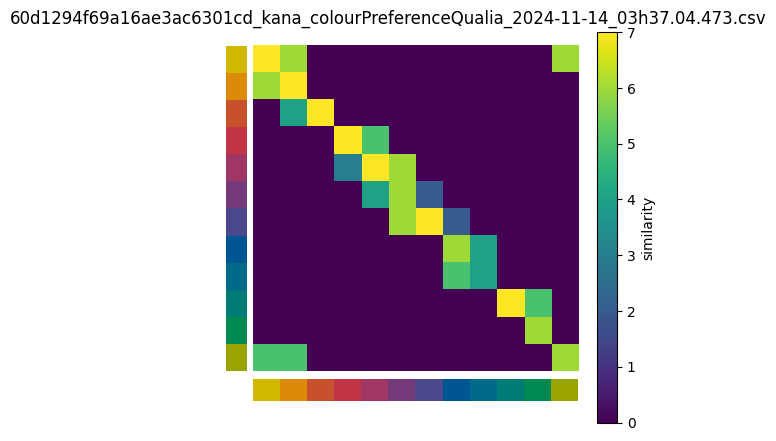

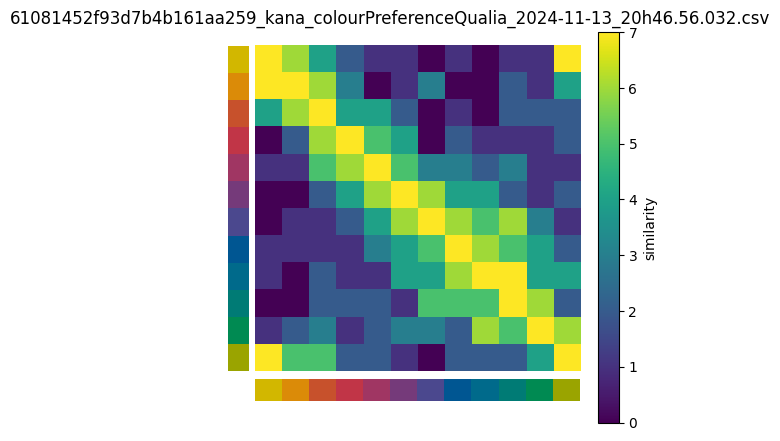

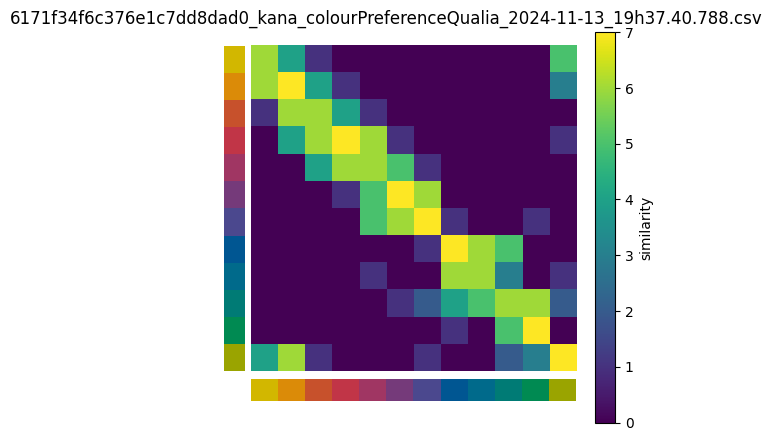

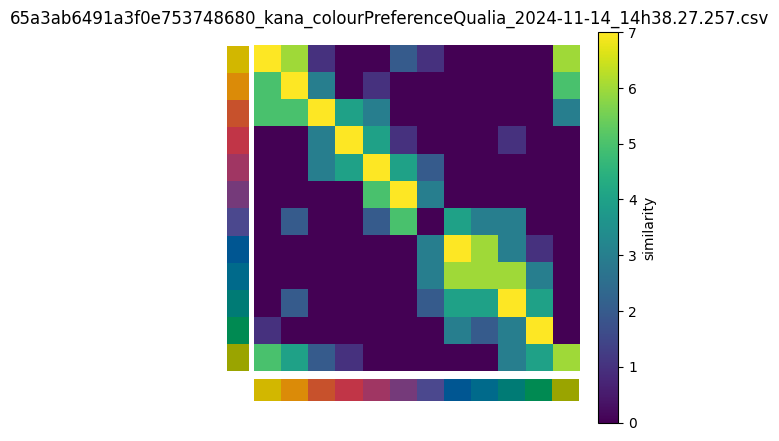

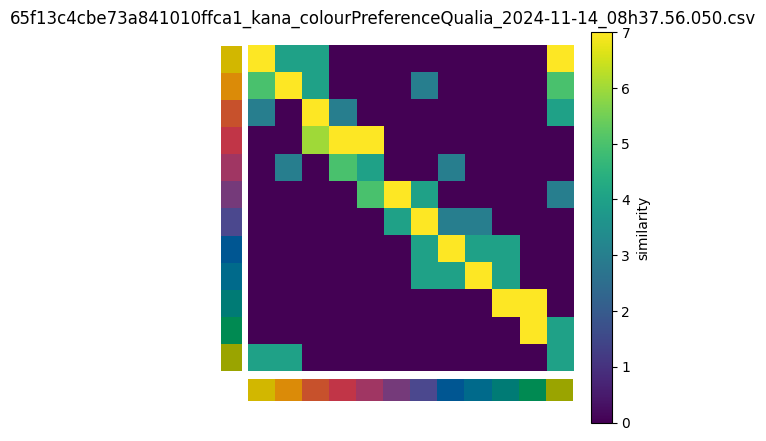

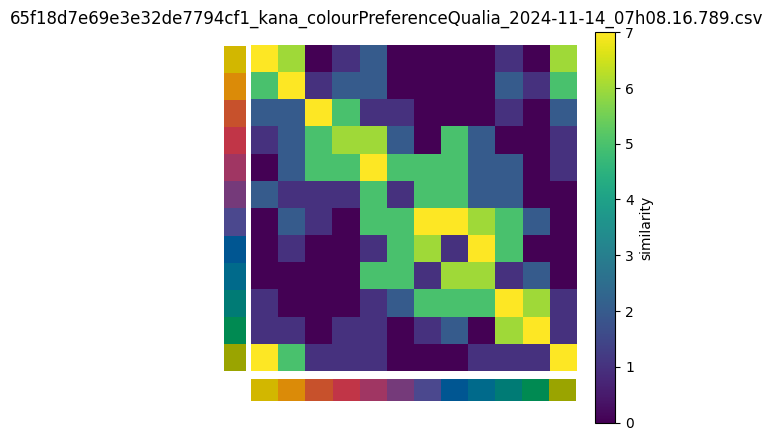

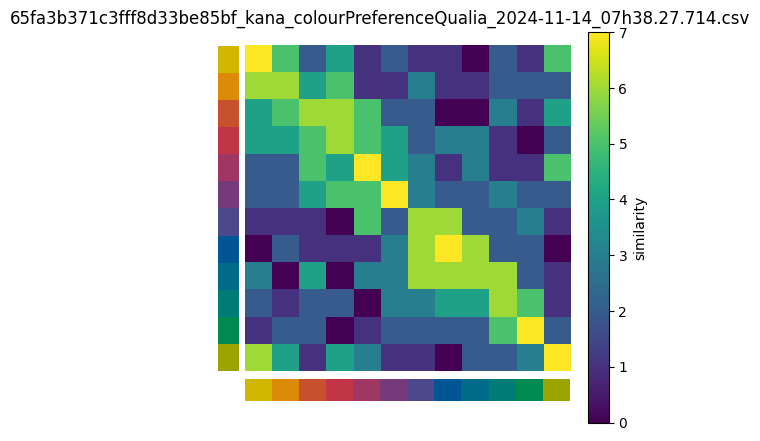

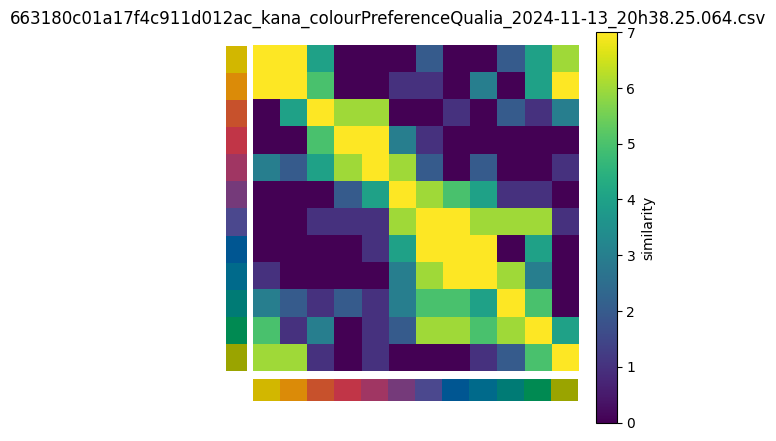

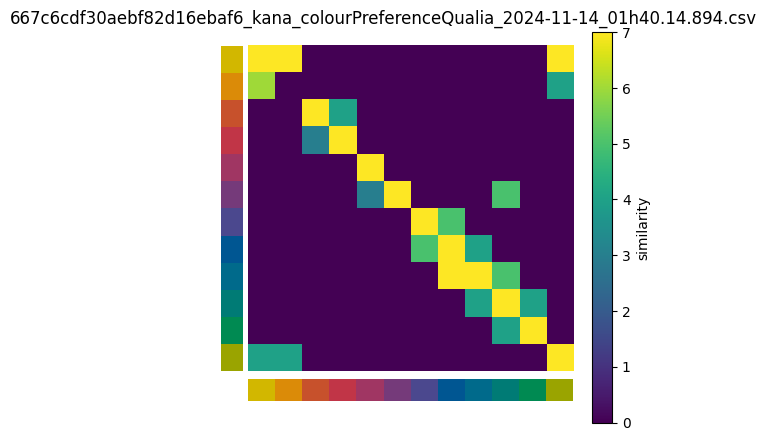

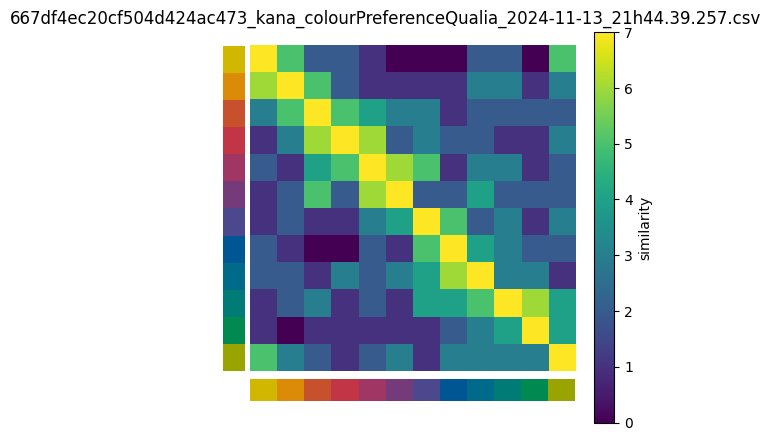

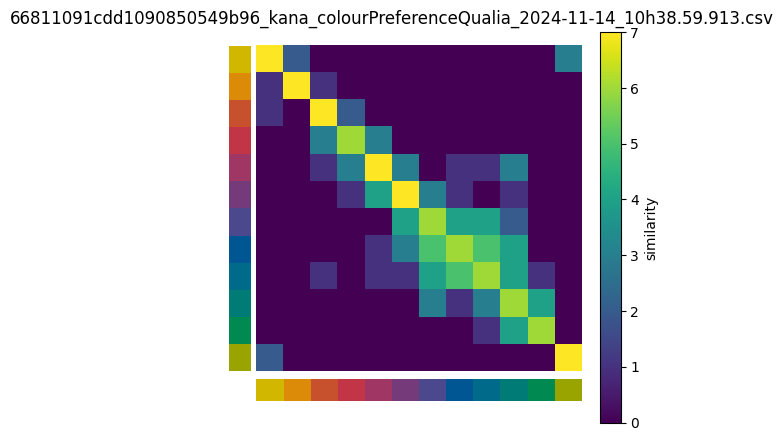

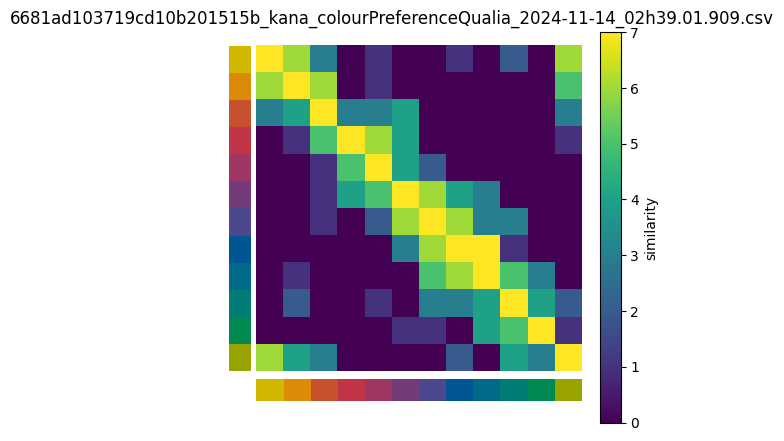

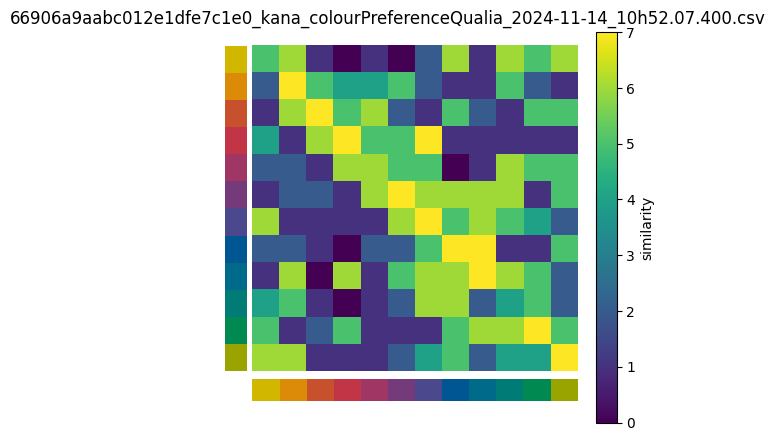

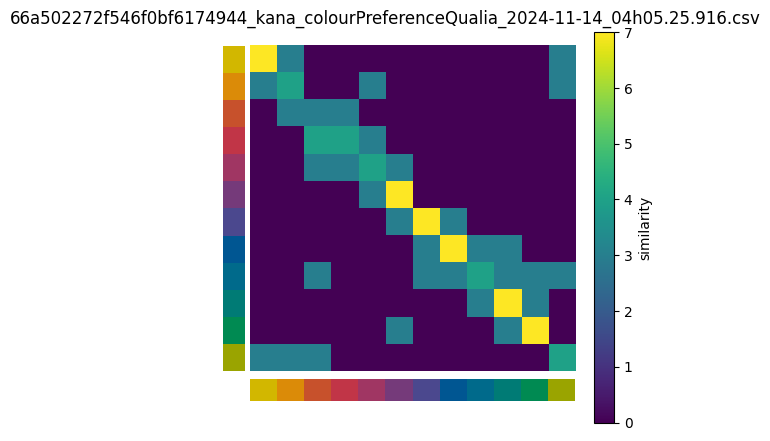

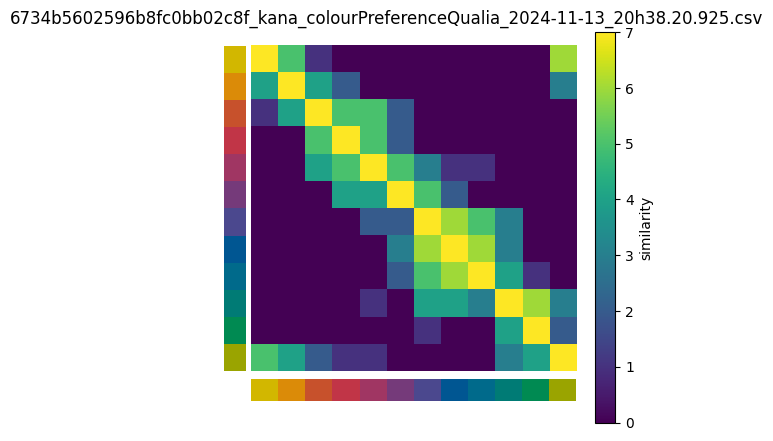

In [8]:
for filename in os.listdir('raw_data/kana_colourpreferencequalia-master/data'):
    if filename.endswith(".csv"):
        filepath = os.path.join('raw_data/kana_colourpreferencequalia-master/data', filename)
        
        # Load the CSV file
        df = pd.read_csv(filepath)

        # Filter for rows where 'response_type' is 'similarity'
        df_similarity = df[df['response_type'] == 'similarity']

        # Extract columns
        colour1 = df_similarity['colour1']
        colour2 = df_similarity['colour2']
        target_preference = df_similarity['response']

        # Create and fill the matrix
        matrix_size = len(colour_index)
        matrix = np.zeros((matrix_size, matrix_size))
        for c1, c2, tp in zip(colour1, colour2, target_preference):
            I = colour_index[c1]
            j = colour_index[c2]
            matrix[j, I] = tp

        # Plot the heatmap for this file
        show_heatmap(matrix, filename, cbar_label="similarity", color_labels=unique_colours)

In [42]:
folder_path = 'raw_data/kana_colourpreferencequalia-master/data'

for filename in os.listdir(folder_path):
    if filename.endswith(".csv"):
        filepath = os.path.join(folder_path, filename)
        
        df = pd.read_csv(filepath, usecols=['response_type', 'response', 'colour1', 'colour2', 'trials.thisIndex', 'practice_trial'])

        # Omit practice trials
        df = df[df['practice_trial'] != 1]  

        df_similarity = df[df['response_type'] == 'similarity']

        # Group by 'trials.thisIndex'
        grouped = df_similarity.groupby('trials.thisIndex')['response'].apply(list).reset_index()

        # Filter for pairs with exactly two trials
        repeated_pairs = grouped[grouped['response'].apply(len) == 2]

        # Check if there are any repeated pairs
        if len(repeated_pairs) > 0:
            # Flatten the responses for repeated pairs
            responses_trial1 = np.array(repeated_pairs['response'].apply(lambda x: x[0]).tolist())
            responses_trial2 = np.array(repeated_pairs['response'].apply(lambda x: x[1]).tolist())

            # Calculate overall correlation for repeated color pairs
            overall_correlation = pearsonr(responses_trial1, responses_trial2)[0]

            print(f"Overall Pearson Correlation for {filename}: {overall_correlation}")
        else:
            print(f"No repeated pairs found in {filename}")

Overall Pearson Correlation for 663180c01a17f4c911d012ac_kana_colourPreferenceQualia_2024-11-13_20h38.25.064.csv: 0.9539037978413332
Overall Pearson Correlation for 6734b5602596b8fc0bb02c8f_kana_colourPreferenceQualia_2024-11-13_20h38.20.925.csv: 0.923069782854075
Overall Pearson Correlation for 65fa3b371c3fff8d33be85bf_kana_colourPreferenceQualia_2024-11-14_07h38.27.714.csv: 0.7610153645142377
Overall Pearson Correlation for 66a502272f546f0bf6174944_kana_colourPreferenceQualia_2024-11-14_04h05.25.916.csv: 0.6335525936249407
Overall Pearson Correlation for 65f18d7e69e3e32de7794cf1_kana_colourPreferenceQualia_2024-11-14_07h08.16.789.csv: 0.7280800135701446
Overall Pearson Correlation for 65f13c4cbe73a841010ffca1_kana_colourPreferenceQualia_2024-11-14_08h37.56.050.csv: 0.5296629148861249
Overall Pearson Correlation for 60d1294f69a16ae3ac6301cd_kana_colourPreferenceQualia_2024-11-14_03h37.04.473.csv: 0.9402983133076948
Overall Pearson Correlation for 609c1037e6c696620986cc20_kana_colourPr